# This notebook describes the costs of operating a Materials Recovery Factory

Data based on Understanding Plastics Recycling by Rudolph et al. 2017

## Some key assumptions 

In [1]:
# Assumptions

assumptions = {
    "Percentage of PET in plastic Waste[%]": 14.16,
    "Average Price of Recycled PET Pellets[$/lb]": 0.58,
    "Price of Recycled PET pellets[$/Kg]": 1.26,
    "Electricity Price[$/kWh]": 0.1027,
    "Diesel Price [$/gallon]": 2.198,
    "Diesel Price [$/l]": 0.5807,
    "Water Price [$/gallon]": 0.015,
    "Water Price [$/l]": 0.004,
    "Lifetime [years]": 10,
    "Processing Building size(Sq.ft)": 0,
    "Waste handled per hour [t]": 30,
    "Yearly waste handling [t]": 120000,
    "Total waste handling (10 years) [t]": 1200000,
    "Residues rate [%]": 2,
    "Correctness of manual sorting [%]": 91,
    "Shifts per Day": 2,
    "Hours per Shift [h]": 8.5,
    "Breaktime per shift [h]": 0.5,
    "Effective working time [h]": 8,
    "Work days per week [days] ": 5,
    "Weeks per Year [weeks]": 52,
    "Yearly working hours [h]": 4160
}

In [2]:
import biosteam as bst
from biosteam import units
from biosteam.units.decorators import cost, CostItem
from compounds import *
from tea import *
import matplotlib.pyplot as plt

## Process Model

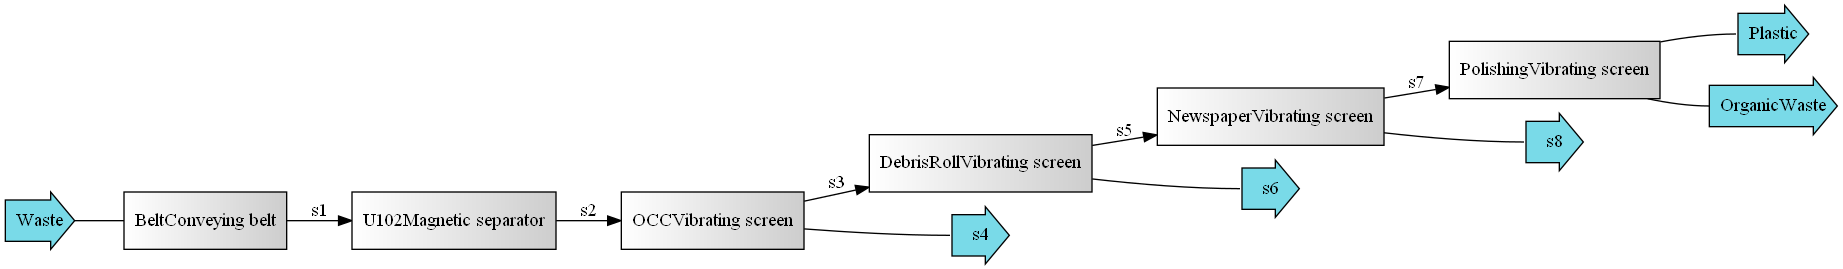

In [4]:
sys_mrf.diagram('thorough')


In [3]:
bst.main_flowsheet.clear()
flowsheet = bst.main_flowsheet.set_flowsheet("MRF")

wastecomposition = chemicals.kwarray(dict(
    PET = assumptions["Percentage of PET in plastic Waste[%]"]/100,
    Al = assumptions["Residues rate [%]"]/100,
    Ash = 1 - assumptions["Percentage of PET in plastic Waste[%]"]/100 - assumptions["Residues rate [%]"]/100))

waste = bst.Stream("Waste",
    flow = assumptions["Waste handled per hour [t]"] * wastecomposition, units="tonnes/hour")

u_belt = units.ConveyingBelt('Belt', ins=waste)
# Separate metals
u_mag_sep = units.MagneticSeparator('U102', ins=u_belt-0)

# Shredder
# u_shredder = units.Shredder('U103', ins=u_mag_sep-0)

# u201 = units.CrushingMill('U201', split=dict(PET=0.9, PE=0.9, PP=0.9, Al=0.1), moisture_content=0)

# Screen out fibers
u_OCC_screen = units.VibratingScreen('OCC', ins=u_mag_sep-0,
                             split=dict(PET=0.99, PE=0.01, PP=0.01, Al=0.99), outs=('', ''))

u_debris_screen = units.VibratingScreen('DebrisRoll', ins=u_OCC_screen-0,
                             split=dict(PET=0.99, PE=0.01, PP=0.01, Al=0.99), outs=('', ''))

u_newspaper_screen = units.VibratingScreen('Newspaper', ins=u_debris_screen-0,
                             split=dict(PET=0.99, PE=0.01, PP=0.01, Al=0.99), outs=('', ''))

u_polishing_screen = units.VibratingScreen('Polishing', ins=u_newspaper_screen-0,
                             split=dict(PET=0.99, PE=0.01, PP=0.01, Al=0.01), outs=('Plastic', 'OrganicWaste'))

plastic = u_polishing_screen-1
residues = u_polishing_screen-0

sys_mrf = bst.main_flowsheet.create_system('mrf')

sys_mrf.simulate()
# sys_mrf.diagram('thorough')
sys_mrf.show()

# the process follows these steps:

System: mrf
ins...
[0] Waste
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4       21.9
                    Al             22.2
                    PubChem=24261  419
outs...
[0] s4
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4       0.219
                    Al             0.222
                    PubChem=24261  419
[1] s6
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  0.217
                    Al        0.22
[2] s8
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  0.214
                    Al        0.218
[3] Plastic
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  21
                    Al        0.216
[4] OrganicWaste
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): C10H10O4  0.212
                    Al        21.4




## Labor costs  

In [5]:
personnel = [
    ["Plant Manager ",  1, 89000, 2],
    ["Operations Foreman",  2, 55000, 2],
    ["Sorters ",  25, 30000, 2],
    ["Scale House Attendant ",  2, 37500, 2],
    ["Equipment Operators",  4, 35000, 2],
    ["Spotters on Tip Floor ",  2, 31000, 2],
    ["Marketing Manager ",  2, 50000, 1]]

def get_labor_cost(position, number, salary, shifts):
    total = (number) * salary * shifts
    return total

labor_costs = sum([get_labor_cost(p, n, s, s1) for (p, n, s, s1) in personnel])
labor_costs
print ("Total labor cost: ${:,.2f}".format(labor_costs))

Total labor cost: $2,552,000.00


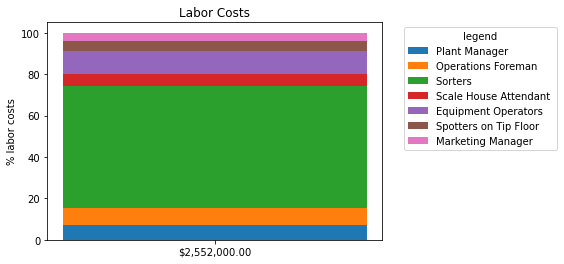

In [6]:
labels= []
labor_cost = []
for i in range(len(personnel)):
    labels.append(personnel[i][0])
    lab = personnel[i][1] *  personnel[i][2] *  personnel[i][3] /2552000 * 100
    labor_cost.append(lab)

fig,ax = plt.subplots()
ax.bar("$2,552,000.00",labor_cost[0],label=labels[0],width = 0.35 )
bot = labor_cost[0]
for item in range(0,6):
    ax.bar("$2,552,000.00",labor_cost[item+1],label=labels[item+1],width = 0.35,bottom =bot )
    bot = bot + labor_cost[item+1]

ax.set_ylabel('% labor costs')
ax.set_title('Labor Costs')
ax.legend( title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
    

## Installation Costs and Waste price

The waste price is based on an assumed tipping fee of $35/tonne.

In [7]:
waste.price = -0.02 # $/kg
plastic.price = 1.0 #$/kg
residues.price = 0 #$/kg

In [8]:
installed_costs = [["Metering bin", 150000.00],
            ["OCC Screen", 175000.00],
            ["Debris Roll Screen", 220000.00],
            ["News paper Screen", 400000.00],
            ["Polishing screen", 280000.00],
            ["Recycling Magnets", 35000.00],
            ["Eddy Current separator", 128000.00],
            ["Optical Plastic sorting machine ", 225000.00],
            ["Baler ", 550000.00],
            ["Conveyor", 50000.00],
            ["Rolling Stock", 350000.00],
            ["Collection Cars", 1000000.00],
            ["Land",675000.00],
            ["Site Work", 720000.00],
            ["Scale House", 600000.00],
            ["MRF Building",8600000.00],
            ["Construction, planning & surveying",3500000.00]]

## Capital Cost Breakdown

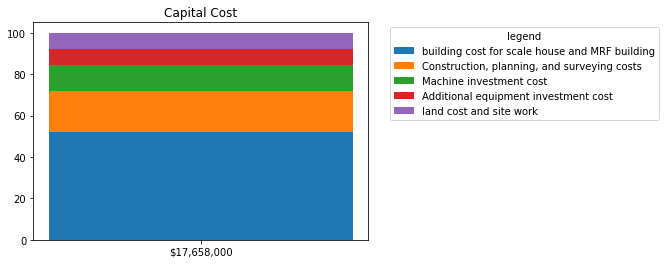

<Figure size 1800x360 with 0 Axes>

In [9]:
total = 17658000
land_cost_and_site_work = 1395000.00 * 100/total
Building_cost  = 9200000.00 * 100/total
Construction_planning_and_surveying_costs = 3500000.00 * 100/total
Machine_investment_cost= 2163000.00 * 100/total
Additional_equipment_investment_cost  = 1400000.00 * 100/total
labels = "$17,658,000"
width = 0.1

fig, ax = plt.subplots()
plt.figure(figsize=(25, 5))


ax.bar(labels, Building_cost, width,label='building cost for scale house and MRF building')
ax.bar(labels,Construction_planning_and_surveying_costs , width,  bottom= Building_cost, label='Construction, planning, and surveying costs')
ax.bar(labels,Machine_investment_cost, width,  bottom= Construction_planning_and_surveying_costs +Building_cost , label='Machine investment cost')
ax.bar(labels,Additional_equipment_investment_cost, width,  bottom= Machine_investment_cost + Construction_planning_and_surveying_costs +Building_cost, label='Additional equipment investment cost ')
ax.bar(labels,land_cost_and_site_work , width, label='land cost and site work',bottom = Additional_equipment_investment_cost + Machine_investment_cost + Construction_planning_and_surveying_costs +Building_cost)
ax.set_title('Capital Cost')

ax.legend( title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

## Analysis 

In [10]:
sys_mrf.simulate()
tea = TEA(
    system=sys_mrf,
    IRR=0.04,
    duration=(2018, 2038),
    depreciation='MACRS7',
    income_tax=0.35,
    operating_days=330,
    lang_factor=1.0,
    construction_schedule=(0.08, 0.6, 0.32),
    WC_over_FCI=0.05,
    labor_cost=labor_costs,
    fringe_benefits=0.4,
    property_tax=0.01,
    property_insurance=0.01,
    supplies=0.20,
    maintenance=0.02,
    administration=0.95,
    equipment=installed_costs)

tea.show()

TEA: mrf
 NPV: 9,011,587 USD at 4.0% IRR


## MFSP ($/tonne)

In [11]:
print ("The minimum selling price of the plastic is ${:,.2f}/tonne".format(1000*tea.solve_price(plastic))) 

The minimum selling price of the plastic is $814.68/tonne


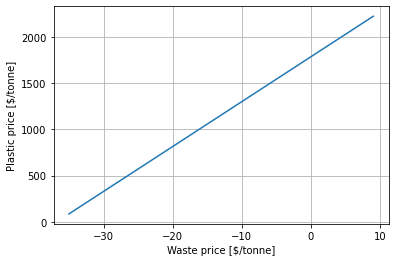

In [13]:
waste_prices = []
plastic_prices = []

for wp in range(-35, 10, 1):
    waste.price = wp/1000
    pp = tea.solve_price(plastic)
    waste_prices.append(wp)
    plastic_prices.append(pp*1000)

plt.plot(waste_prices, plastic_prices)
plt.xlabel("Waste price [$/tonne]")
plt.ylabel("Plastic price [$/tonne]")
plt.grid()

Here we assume that the waste has a tipping of $35/tonne but the MRF has to pay for its transportation costs as it scales.

The base case transportation cost is assumed to be $36.8/tonne with a scaling factor of 1.3

Text(0, 0.5, 'Plastic price [$/tonne]')

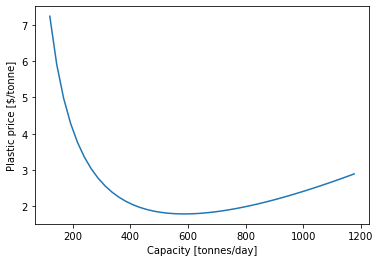

In [14]:
capacities = range(5*24, 50*24, 1*24)
plastic_prices = []
waste.price = -0.035

for c in capacities:
    waste.price = 0.0368*(c/24/30)**1.3 - 0.035
    waste.set_total_flow(c/24, 'tonnes/hour')
    tea.system.simulate()
    plastic_prices.append(tea.solve_price(plastic))

plt.plot(capacities, plastic_prices)
plt.xlabel("Capacity [tonnes/day]")
plt.ylabel("Plastic price [$/tonne]")

In [ ]:
# labels= []
# installed_cost = []
# ins_cost = 0
# for i in range(len(installed_costs)):
#     labels.append(installed_costs[i][0])
#     ins_cost = installed_costs[i][1]/17658000.0 * 100
#     installed_cost.append(ins_cost)

# fig,ax = plt.subplots()
# ax.bar("$17,658,000",installed_cost[0],label=labels[0],width = 0.35 )
# bot = installed_cost[0]
# for item in range(0,16):
#     ax.bar("$17,658,000",installed_cost[item+1],label=labels[item+1],width = 0.35,bottom =bot )
#     bot = bot + installed_cost[item+1]

# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.legend( title='legend', bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.show()
    

In [ ]:
# Transportation_and_collection_cost = 4420800
# Residues_Costs = 96000 
# Rolling_stock_O&M_costs = 897080
# Conveyor_O&M_costs = 12392.50
# Machine_O&M_cost_per_year = 128565.09
# Facility_costs_per_year 
# Personnel_salaries_per_year 